In [2]:
%config Completer.use_jedi = False
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [3]:
A = np.array([[-1,0,0,0],[0,-1,0,0],[1,0,0,0],[0,1,0,0]])
B = np.array([[1,0],[0,1],[0,0],[0,0]])
I = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
Te = 0.01
F = I+A*Te
G = B*Te

# Drone State Space Equations
def DroneSys(xk,uk):
    xk = np.resize(xk,(4,1))
    uk = np.resize(uk,(2,1))
    return F@xk + G@uk

In [4]:
N = 1000

# Simulation
def Simul(sys,U):
    X = np.ones((4,N))*0
    for i in range(N-1):
        X[:,i+1] = sys(X[:,i],U[:,i]).T
    t = np.arange(N)*Te
    plt.figure()
    plt.title('x')
    plt.plot(t,X[0,:])
    plt.plot(t,U[0,:])
    plt.figure()
    plt.title('y')
    plt.plot(t,X[1,:])
    plt.plot(t,U[1,:])

<IPython.core.display.Javascript object>


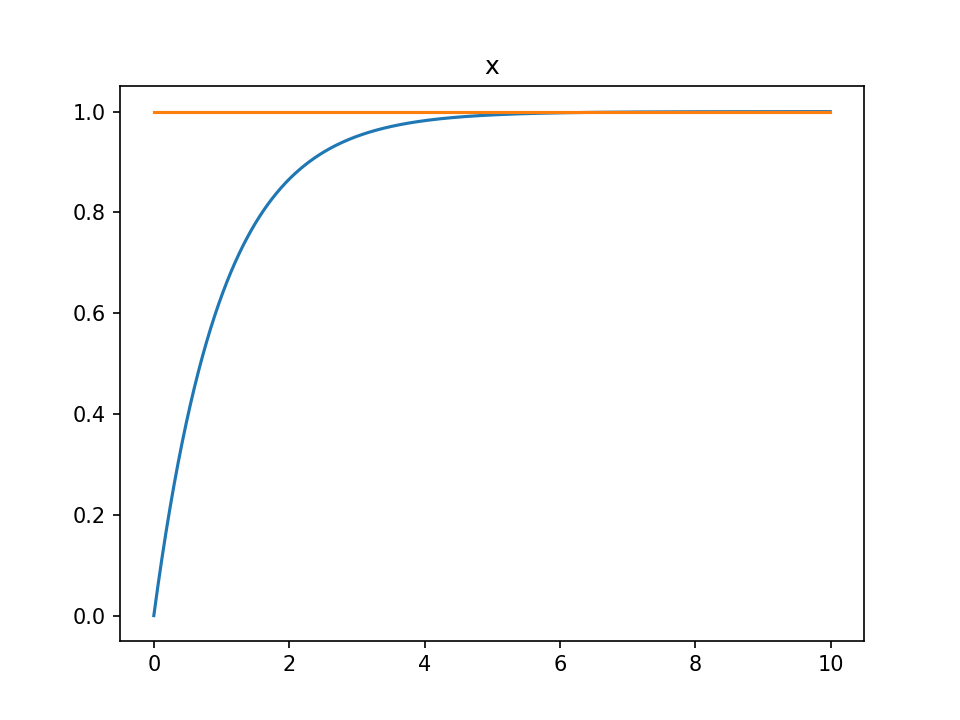

<IPython.core.display.Javascript object>


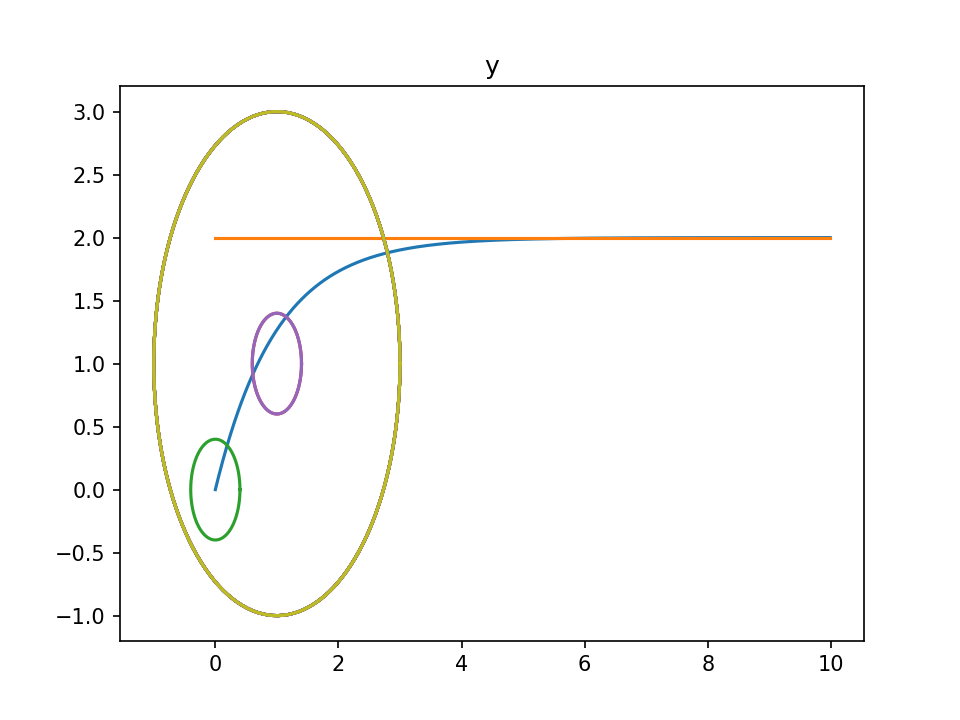

In [4]:
U = np.array([np.ones(N),np.ones(N)*2])
Simul(DroneSys,U)

In [107]:
kl = 1

# Region parameters
r1 = 1
xo1 = 0
yo1 = 0

rc = .5 # Proximity radius limit

def PlotCircle(r,x0,y0):
    angle = np.linspace( 0 , 2 * np.pi , 150 )
    x = r * np.cos( angle ) + x0
    y = r * np.sin( angle ) + y0
    plt.plot( x, y )

circle = lambda r, xi, yi, xj, yj : r**2 - (xi - xj)**2 - (yi - yj)**2
    
def gof_circle(r,xi,yi,xj,yj):
    return max([0, -circle(r,xi,yi,xj,yj)])

def gof_ccircle(r,xi,yi,xj,yj):
    return max([0, circle(r,xi,yi,xj,yj)])

def DeltaXi(r,xi,yi,xj,yj):
    return kl*gof_circle(r,xi,yi,xj,yj)*np.array([[2*(xi - xj)],
                                                     [2*(yi - yj)]])

def DeltaRho(r,xi,yi,xj,yj):
    return kl*gof_ccircle(r,xi,yi,xj,yj)*np.array([[-2*(xi - xj)],
                                                    [-2*(yi - yj)]])


<IPython.core.display.Javascript object>


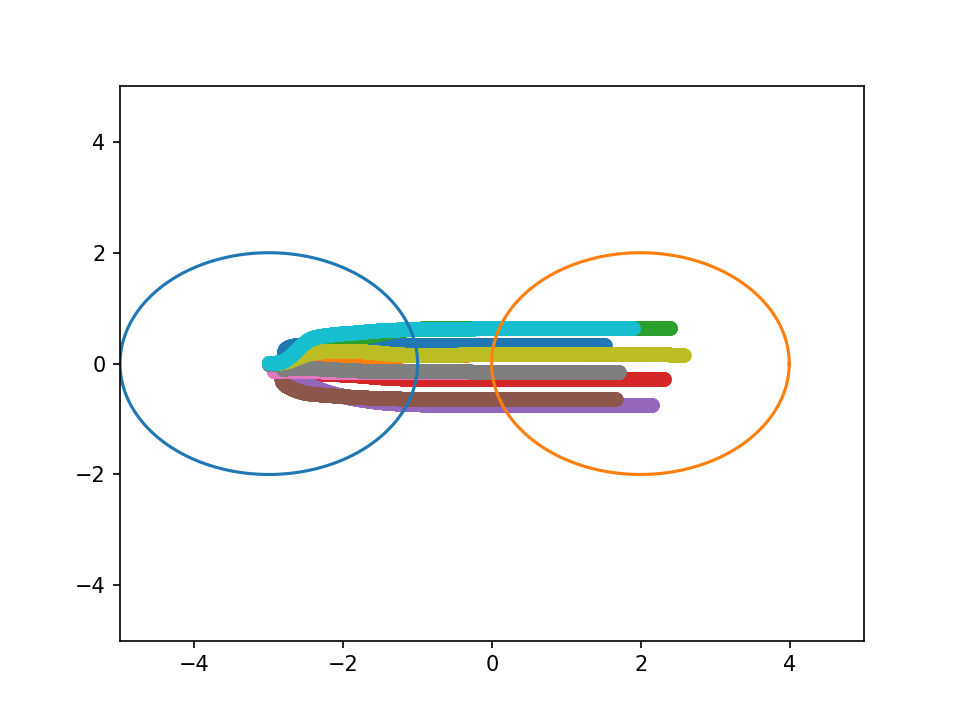

<IPython.core.display.Javascript object>


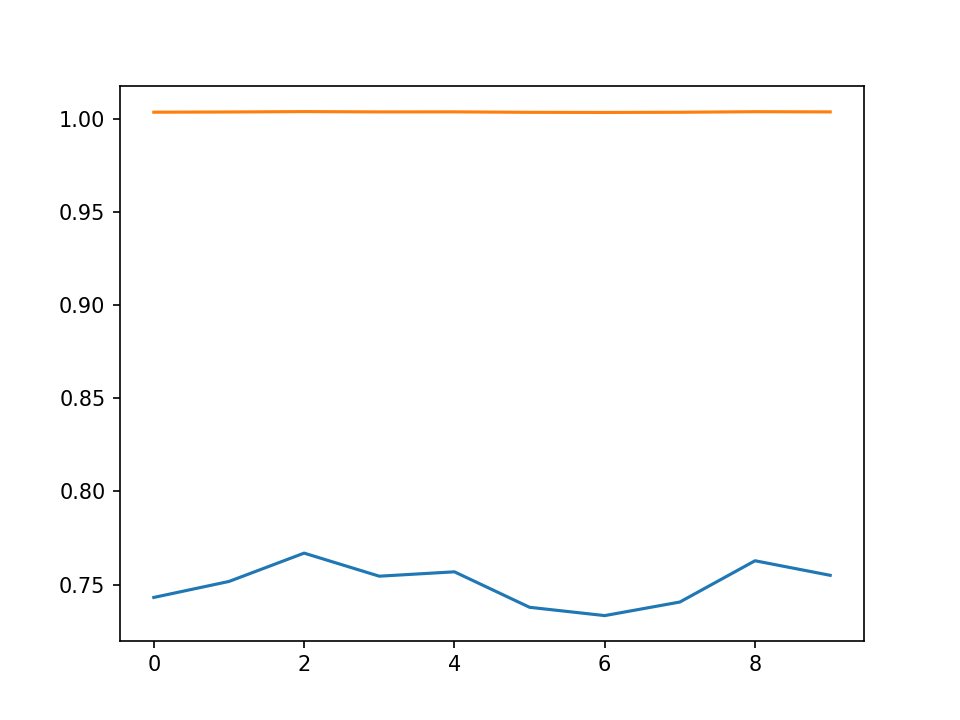

In [181]:
N = 1000
nbrob = 10
Ksi = 10
Kp = 10
lim = 5

rp = 0.5
rc = 2

alpha = 1
gamma = 1
Li = np.eye(2)*1e-0

# Simulation
def Simul2D(sys,ref):
    Xs = np.ones((nbrob,4,N))
    Xpri = np.zeros((2,nbrob))
    Theta = np.zeros((nbrob,2,N))
    CircleCenter = np.array([np.ones(N)*-3,np.zeros(N)])
    
    for i in range(nbrob):
        Xs[i] = np.array([np.zeros(N),
                          np.zeros(N),
                          np.ones(N)*(-3 + (np.random.rand()-0.5)/100),
                          np.ones(N)*((np.random.rand()-0.5))/100])
        Theta[i] = np.array([np.ones(N)*0.5,
                          np.ones(N)])
    
    for i in range(N-1):
        for j in range(nbrob):
            
            deltaXi = DeltaXi(rc,Xs[j,2,i],Xs[j,3,i],CircleCenter[0,i],CircleCenter[1,i])
            deltaRho = 0
            
            for k in range(nbrob):
                if k == j:
                    continue 
                deltaRho += DeltaRho(rp,Xs[j,2,i],Xs[j,3,i],Xs[k,2,i],Xs[k,3,i])

            deltaEps = alpha*deltaXi + gamma*deltaRho
            xpri = np.reshape(ref[:,i],(2,1)) - deltaEps
            si = np.reshape(Xs[j,0:2,i],(2,1)) - xpri
            Yi = np.zeros((2,2))
            Yi[:,0] = (xpri.T - Xpri[:,j])/Te
            Yi[:,1] = xpri.T
            Xpri[:,j] = xpri.T
            u = -Ksi*si - Kp*deltaEps + Yi@np.reshape(Theta[j,:,i],(2,1))
            
            Xs[j,:,i+1] = sys(Xs[j,:,i],u).T
            Theta[j,:,i+1] = Theta[j,:,i] - (Li@Yi.T@si).T*Te
            
        CircleCenter[:,i+1]  = CircleCenter[:,i] + ref[:,i]*Te
        
    plt.figure()
    for i in range(nbrob):
        plt.scatter(Xs[i,2,:],Xs[i,3,:])
    PlotCircle(rc,CircleCenter[0,0],CircleCenter[1,0])
    PlotCircle(rc,CircleCenter[0,-1],CircleCenter[1,-1])
    plt.xlim([-lim,lim])
    plt.ylim([-lim,lim])
    
    plt.figure()
    plt.plot(Theta[:,0,2])
    plt.plot(Theta[:,1,2])
ref = np.array([np.ones(N)*.5,np.ones(N)*.0])
Simul2D(DroneSys,ref)

In [122]:
Xpri = np.zeros(nbrob)
Xpri

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [176]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])